In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.subplots as sub
import dash
from dash import dcc, html, Output, Input, State
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, top_k_accuracy_score
from sklearn.model_selection import StratifiedKFold
import optuna
from optuna.trial import TrialState
from optuna.integration import PyTorchIgnitePruningHandler

from functools import partial
import random
import os
import itertools
from PIL import Image
from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torchvision
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, Subset
from torchvision.models import vgg16_bn, resnet50, resnet18, efficientnet_b0, densenet121, ResNet50_Weights, ResNet18_Weights, VGG16_BN_Weights, DenseNet121_Weights, EfficientNet_B0_Weights
from torchvision.utils import make_grid, draw_bounding_boxes, draw_segmentation_masks, draw_keypoints
from torchvision import datasets
from torchvision.transforms import ToTensor, v2, ToPILImage
from torchvision.io import decode_image

# from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
# from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
# from ignite.handlers import ModelCheckpoint, EarlyStopping

from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torch.amp import GradScaler, autocast

from transformers import ViTForImageClassification, ViTImageProcessor, AutoModelForImageClassification, AutoImageProcessor, Trainer, TrainingArguments
from huggingface_hub import snapshot_download, hf_hub_download
import socket
import json
import sys

In [4]:
# Starting from chocp/, go up two levels to parent_dir/
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))

# Prepend to sys.path so Python can find src/
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)



from src.chocp_dataset import FGVCAircraftDataset

In [10]:
ds_hf = FGVCAircraftDataset(
    root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data",
    split="test", level="manufacturer", transform=None
)

In [11]:
ds_hf[0]

(<PIL.Image.Image image mode=RGB size=1200x882>, 4)

In [16]:
# SE Module
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ResNet50 with SE Block
class SEEffNet(nn.Module):
    def __init__(self, num_classes=30, drop=0.0):
        super(SEEffNet, self).__init__()
        self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.backbone.classifier = nn.Identity() # fc if resnet
        self.se = SEBlock(in_channels=1280) #2048 for resnet, 1280 for efficientnet, densenet121 = 1024, final layer also classifier
        self.dropout = nn.Dropout(drop)
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = self.se(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [13]:
def get_loaders(img_size = 224, batch_size = 32, annot = 'manufacturer'):
    mean=[0.485,0.456,0.406]
    std=[0.229,0.224,0.225]

    train_tf = A.Compose([
        A.RandomResizedCrop((img_size, img_size)),  # A.Resize(img_size, img_size)
        A.HorizontalFlip(p=0.5),
        A.Affine(scale=(0.9, 1.1), translate_percent=(0.05, 0.05), rotate=(-15, 15), p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    test_tf = A.Compose([
        #A.LongestMaxSize(max_size=256)
        A.Resize(img_size, img_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])
    
    train_dataset = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", 
                                        split='train', level = annot, transform=train_tf, return_class=False, 
                                        cropped=True, album = True)
    val_dataset   = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", 
                                        split='val', level = annot, transform=test_tf, 
                                        return_class=False, cropped=False, album = True)
    test_dataset   = FGVCAircraftDataset(root="C:/Users/chihp/UMich/SIADS/699/FGVC/fgvc-aircraft-2013b/data", 
                                         split='test', level = annot, transform=test_tf, 
                                         return_class=False, cropped=False, album = True)
    class_names = train_dataset.classes
    num_classes = len(train_dataset.classes)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    return train_loader, val_loader, test_loader, num_classes, class_names

In [7]:
# For evaluation of valid set
def top_k_accuracy(output, target, k=5):
    with torch.no_grad():
        max_k_preds = output.topk(k, dim=1)[1]
        correct = max_k_preds.eq(target.view(-1, 1).expand_as(max_k_preds))
        return correct.any(dim=1).float().mean().item()

# For evaluation of final test set

def compute_metrics(y_true, y_pred_logits, k=5):
    """
    Computes Top-1 and Top-k accuracy, and macro/micro F1 scores.
    
    Parameters:
    - y_true: Ground truth labels (list or numpy array)
    - y_pred_logits: Model output logits (tensor or numpy array)
    - k: Value for Top-k accuracy
    
    Returns:
    - Dictionary of metrics
    """
    # Convert logits to predicted labels
    y_pred_top1 = torch.argmax(y_pred_logits, dim=1).cpu().numpy()
    y_true_np = y_true.cpu().numpy() if isinstance(y_true, torch.Tensor) else y_true
    y_pred_np = y_pred_logits.cpu().numpy() if isinstance(y_pred_logits, torch.Tensor) else y_pred_logits

    # Compute metrics
    top1_acc = top_k_accuracy_score(y_true_np, y_pred_np, k=1)
    topk_acc = top_k_accuracy_score(y_true_np, y_pred_np, k=k)
    f1_macro = f1_score(y_true_np, y_pred_top1, average='macro')
    f1_micro = f1_score(y_true_np, y_pred_top1, average='micro')

    return {
        'Top-1 Accuracy': top1_acc,
        f'Top-{k} Accuracy': topk_acc,
        'F1 Macro': f1_macro,
        'F1 Micro': f1_micro
    }



In [8]:
# Training and evaluation functions
def train_one_epoch(model, dataloader, criterion, optimizer, device, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    loss_lst = []
    acc_lst = []

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        #inputs, labels = cutmix_or_mixup(inputs, labels)#cutmix/mixup
        inputs, labels = inputs.to(device), labels.to(device)
        #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup

        optimizer.zero_grad()
        outputs = model(inputs)#
        loss = criterion(outputs, labels)#
        loss.backward()#
        optimizer.step()#
        # with autocast(device_type = 'cuda'):
        #     outputs = model(inputs)
        #     loss = criterion(outputs, labels)
        # scaler.scale(loss).backward()
        # scaler.step(optimizer)
        # scaler.update()
        

        running_loss += loss.item() * inputs.size(0)
        #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)
        loss_lst.append(loss.item() * inputs.size(0))#
        acc_lst.append(predicted.eq(labels).sum().item() / labels.size(0))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    #loss_lst.append(epoch_loss)
    #acc_lst.append(epoch_acc)
    return epoch_loss, epoch_acc, loss_lst, acc_lst

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    loss_lst = []
    acc_lst = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc = "Evaluation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            

            running_loss += loss.item() * inputs.size(0)
            #hard_labels = labels.argmax(dim=1) #convert soft label to hard labels for cutmix or mixup
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loss_lst.append(loss.item() * inputs.size(0))#
            acc_lst.append(predicted.eq(labels).sum().item() / labels.size(0))

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    #loss_lst.append(epoch_loss)
    #acc_lst.append(epoch_acc)
    return epoch_loss, epoch_acc, all_preds, all_labels, loss_lst, acc_lst



# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
# def plot_confusion_matrix(model, data_loader, class_names):
#     model.eval()
#     all_preds = []
#     all_labels = []

#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             _, preds = torch.max(outputs, 1)  # <-- This line was missing
#             all_preds.extend(preds.cpu().numpy())
#             all_labels.extend(labels.cpu().numpy())
    
#     cm = confusion_matrix(all_labels, all_preds)
#     plt.figure(figsize=(12, 8))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#                 xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title('Confusion Matrix')
#     plt.show()

def unnormalize(img_tensor, mean, std):
    for t, m, s in zip(img_tensor, mean, std):
        t.mul_(s).add_(m)
    return img_tensor

def visualize_predictions(model, test_dataset, num_samples=10, normalized=True):
    model.eval()
    samples = random.sample(range(len(test_dataset)), num_samples)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()

    inv_label_map = test_dataset.idx_to_class
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    with torch.no_grad():
        for idx, sample_idx in enumerate(samples):
            image, label = test_dataset[sample_idx]
            input_img = image.unsqueeze(0).to(device)
            output = model(input_img)
            _, pred = torch.max(output, 1)

            # Unnormalize if needed
            if normalized:
                image = unnormalize(image.clone(), mean, std)

            img_disp = image.permute(1, 2, 0).cpu().numpy().clip(0, 1)
            axes[idx].imshow(img_disp)
            axes[idx].set_title(f"Pred: {inv_label_map[pred.item()]}\nActual: {inv_label_map[label]}")
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()


In [14]:
train_loader, val_loader, test_loader, num_classes, class_names = get_loaders(224,32,'variant')

In [17]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model, loss function, and optimizer
#num_classes = len(train_dataset.label_map)
#model = HWCNN(num_classes).to(device)
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
scaler = GradScaler('cuda')

model = SEEffNet(num_classes).to(device)

#criterion = SoftTargetCrossEntropy() # or nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()#label_smoothing = 0.1)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer = optim.AdamW(model.parameters(), lr=0.000085, weight_decay = 0.000009)#70
#optimizer = optim.AdamW(model.parameters(), lr=0.000238, weight_decay = 0.00052)#30
#optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
#optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, res50.parameters()), lr = 0.001, momentum = 0.9, weight_decay = 0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

In [18]:
# Training loop with early stopping and adaptive learning rate
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0
num_epochs = 80


In [19]:
%%time
train_loss_lst =[]
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []
all_val_preds = []
all_val_labels = []


for epoch in range(num_epochs):

    train_loss, train_acc, t_loss_lst, t__acc_lst = train_one_epoch(model, train_loader, criterion, optimizer, device, scaler)
    val_loss, val_acc, val_preds, val_labels, v_loss_lst, v_acc_lst = evaluate(model, val_loader, criterion, device)
    train_loss_lst.append(train_loss)
    train_acc_lst.append(train_acc)
    val_loss_lst.append(val_loss)
    val_acc_lst.append(val_acc)
    
    all_val_preds.extend(val_preds)
    all_val_labels.extend(val_labels)


    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
        print("✅ Model improved. Saving...")
    else:
        epochs_without_improvement += 1
        print(f"⚠️ No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= patience:
        print("⏹️ Early stopping triggered.")
        break



Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/80
Train Loss: 4.1960, Train Acc: 0.0627
Val Loss: 4.4065, Val Acc: 0.0510
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/80
Train Loss: 3.3532, Train Acc: 0.1623
Val Loss: 4.4834, Val Acc: 0.0723
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/80
Train Loss: 2.9212, Train Acc: 0.2232
Val Loss: 4.1341, Val Acc: 0.0999
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/80
Train Loss: 2.6233, Train Acc: 0.2855
Val Loss: 4.2085, Val Acc: 0.0795
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/80
Train Loss: 2.3540, Train Acc: 0.3350
Val Loss: 4.7598, Val Acc: 0.1074
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/80
Train Loss: 2.1130, Train Acc: 0.3860
Val Loss: 4.3573, Val Acc: 0.0948
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/80
Train Loss: 1.9992, Train Acc: 0.4142
Val Loss: 4.2410, Val Acc: 0.1053
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/80
Train Loss: 1.6431, Train Acc: 0.5156
Val Loss: 3.9060, Val Acc: 0.1512
✅ Model improved. Saving...


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/80
Train Loss: 1.4215, Train Acc: 0.5576
Val Loss: 4.2526, Val Acc: 0.1437
⚠️ No improvement for 1 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/80
Train Loss: 1.3366, Train Acc: 0.5987
Val Loss: 4.2378, Val Acc: 0.1566
⚠️ No improvement for 2 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/80
Train Loss: 1.2994, Train Acc: 0.6017
Val Loss: 4.3997, Val Acc: 0.1434
⚠️ No improvement for 3 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/80
Train Loss: 1.2415, Train Acc: 0.6203
Val Loss: 4.3724, Val Acc: 0.1377
⚠️ No improvement for 4 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/80
Train Loss: 1.0636, Train Acc: 0.6833
Val Loss: 4.0894, Val Acc: 0.1635
⚠️ No improvement for 5 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/80
Train Loss: 1.0156, Train Acc: 0.6956
Val Loss: 4.1850, Val Acc: 0.1623
⚠️ No improvement for 6 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/80
Train Loss: 0.9401, Train Acc: 0.7109
Val Loss: 4.1329, Val Acc: 0.1716
⚠️ No improvement for 7 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/80
Train Loss: 0.8998, Train Acc: 0.7292
Val Loss: 4.1110, Val Acc: 0.1854
⚠️ No improvement for 8 epoch(s).


Training:   0%|          | 0/105 [00:00<?, ?it/s]

KeyboardInterrupt: 

[FGVC][resnet50] Epoch 01 → Acc=0.0681  P=0.0382  R=0.0681  F1=0.0290
[FGVC][resnet50] Epoch 02 → Acc=0.1095  P=0.0843  R=0.1095  F1=0.0649
[FGVC][resnet50] Epoch 03 → Acc=0.1320  P=0.1182  R=0.1320  F1=0.0958


C:\Users\chihp\anaconda3\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


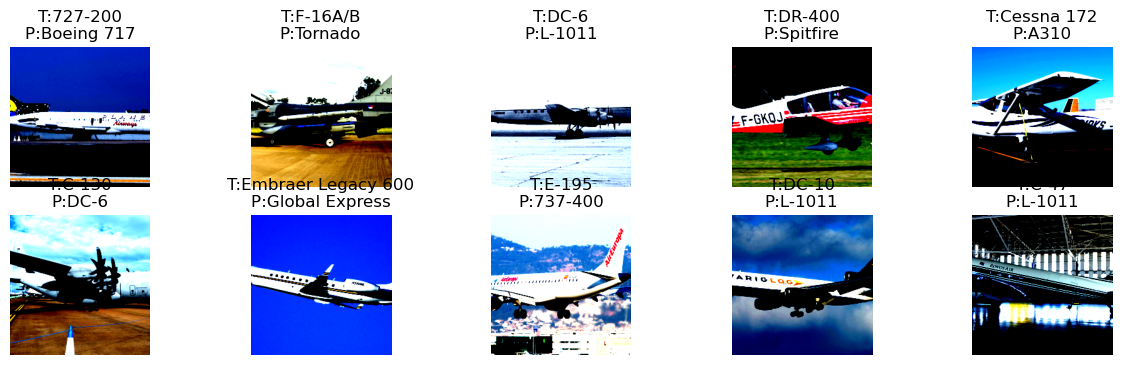

In [ ]:
model.eval()
final_preds = []
final_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Final Evaluation", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        final_preds.append(outputs.cpu())
        final_labels.append(labels.cpu())

final_preds = torch.cat(final_preds)
final_labels = torch.cat(final_labels)

final_metrics = compute_metrics(final_labels, final_preds, k=5)
print("Final Evaluation Metrics:")
for key, value in final_metrics.items():
    print(f"{key}: {value:.4f}")

In [ ]:
cm = confusion_matrix(all_val_labels, all_val_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
class_accuracy = np.diag(cm_normalized)
tick_marks = np.arange(len(class_names))

In [ ]:
# Create heatmap using Plotly
heatmap = go.Heatmap(
    z=cm_normalized,
    x=class_names,
    y=class_names,
    colorscale='Plasma',
    colorbar=dict(title='Accuracy'),
    hovertemplate='Actual: %{y}<br>Predicted: %{x}<br>Accuracy: %{z:.2%}<extra></extra>'
)

# Create scatter plot (lollipop style) for class accuracy
scatter = go.Scatter(
    x=class_names,
    y=class_accuracy,
    mode='markers+lines',
    marker=dict(size=8, color='blue'),
    line=dict(color='lightblue'),
    name='Class Accuracy',
    hovertemplate='Class: %{x}<br>Accuracy: %{y:.2%}<extra></extra>'
)

# Create subplots with corrected keyword 'shared_xaxes'
fig = sub.make_subplots(
    rows=2, cols=1,
    row_heights=[0.7, 0.3],
    shared_xaxes=True,
    vertical_spacing=0.05,
    subplot_titles=("Normalized Confusion Matrix", "Accuracy per Class")
)

fig.add_trace(heatmap, row=1, col=1)
fig.add_trace(scatter, row=2, col=1)

fig.update_layout(
    height=1000,
    width=1200,
    title_text="Interactive Confusion Matrix with Class Accuracy",
    xaxis2=dict(tickangle=90),
    margin=dict(t=100)
)

fig.write_html("interactive_confusion_matrix.html")
print("Interactive confusion matrix with class accuracy saved as 'interactive_confusion_matrix.html'.")
fig.show()


In [ ]:
# Sample data (replace these lists with actual collected data)
# train_losses = [2.0, 1.8, 1.5, 1.2, 1.0, 0.8, 0.6, 0.5, 0.4, 0.3]
# val_losses = [2.1, 1.9, 1.6, 1.3, 1.1, 0.9, 0.7, 0.6, 0.5, 0.4]
# train_accuracies = [0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
# val_accuracies = [0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]

ep = range(1, len(train_loss_lst) + 1)

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ep, train_loss_lst, label='Training Loss')
plt.plot(ep, val_loss_lst, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(ep, train_acc_lst, label='Training Accuracy')
plt.plot(ep, val_acc_lst, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
train_dataset, val_dataset, test_dataset = get_datasets(224,32,'variant')

In [ ]:
visualize_predictions(model, test_dataset)